# Mudcard
- **For quiz 1, if we display the output of the confusion matrix, I am curious about how to interpret this output [[5 2 0] [1 3 1] [1 1 2]]**
    - it is a 3x3 confusion matrix because there are three different classes
    - the meaning of the confusi9on matrix doesn't change, C_ij is equal to the number of observations known to be in group but predicted to be in group
    - the only difference is that i and j can be 0, 1, or 2.
- **why not use multiple imputation?**
    - imputation generally can be very misleading
    - imputation can reduce the variance of the feature, it can distort the relationship between the imputed feature and the target variable, it can hide data quality issues, and it can reduce model performance
- **still confused on how to choose a metric - should we use fscore by default?**
    - no, there is no default metric
    - it depends on what your model will do once it is deployed
    - in classification models, the question usually comes down to the 'cost' of model's mistakes
    - which is worse? false positives or false negatives?
- **What is the meaning of f-beta score? What does the score indicate about the dataset?**
    - evaluation metrics don't usually indicate anything about your dataset
    - they measure the quality of the predictions of a machine learning model
    - let's discuss first the f1 score
        - precision and recall are often in tension with each other
        - a model that has good recall, often has poor precision and vice versa
        - the f1 score tries to force the model to be good at both at the same time
        - the way this is achieved by the geometric mean of precision and recall
        - if either precision or recall are low, the overall f1 score is low as well
        - that's not necessarily true for other ways of averaging the two scores
    - the f-beta score is a generalization of the f1 score where you can choose how much you care about precision vs recall
        - if beta > 1, recall gets more weight, it is considered more important
        - if beta < 1, precision gets more weight, it is considered more important


## Evaluation metrics in supervised ML, part 2, predicted probabilities and regression metrics

By the end of this lecture, you will be able to
- Summarize the ROC and precision-recall curves, and the logloss metric
- Describe the most commonly used regression metrics


## <font color='LIGHTGRAY'> Evaluation metrics in supervised ML, part 2, predicted probabilities and regression</font>

<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- **Summarize the ROC and precision-recall curves, and the logloss metric**
- <font color='LIGHTGRAY'>Describe the most commonly used regression metrics</font>


### The ROC curve
- Receiver Operating Characteristic
   - x axis: false positive rate (fpr = FP / (FP + TN))
   - y axis: true positive rate (R = TP / (TP + FN))
   - the curve shows fpr and R value pairs for various class 1 critical probabilities
- upper left corner: perfect predictor
- diagonal point: chance level predictions
- lower right corner: worst predictor

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
df = pd.read_csv('../data/true_labels_pred_probs.csv')

y_true = df['y_true']
pred_prob_class1 = df['pred_prob_class1']
pred_prob_class0 = df['pred_prob_class0']

fpr = np.zeros(len(y_true))
tpr = np.zeros(len(y_true))

p_crits = np.sort(pred_prob_class1) # the sorted predicted probabilities serve as critical probabilities

for i in range(len(p_crits)):
    p_crit = p_crits[i]
    
    y_pred = np.zeros(len(y_true))
    y_pred[pred_prob_class1 < p_crit] = 0
    y_pred[pred_prob_class1 >= p_crit] = 1
    
    C = confusion_matrix(y_true,y_pred) 
    
    tpr[i] = C[1,1]/(C[1,0]+C[1,1])
    fpr[i] = C[0,1]/(C[0,0]+C[0,1])

from sklearn.metrics import roc_curve
# # the roc_curve function performs the same calculation
fpr,tpr,p_crits = roc_curve(y_true,pred_prob_class1)


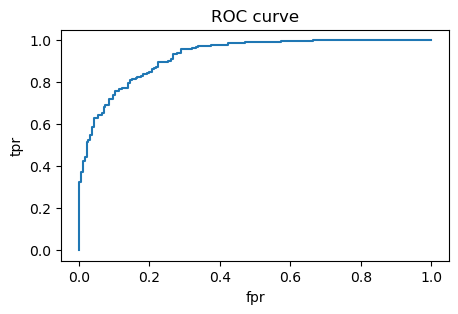

In [2]:
plt.figure(figsize=(5,3))
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

## Quiz 1
What's the (fpr,tpr) coordinate on the ROC curve if p_crit = 1?

## ROC AUC
- ROC is useful but it is not a single number metric
   - it cannot be directly used to compare various classification models
- summary statistics based on the ROC curve (for a complete list, see [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Further_interpretations))
- most commonly used metric is ROC AUC - ROC Area Under the Curve
   - AUC = 1 is a perfect classifier
   - AUC > 0.5 is above chance-level predictor
   - AUC = 0.5 is a chance-level classifier
   - AUC < 0.5 is a bad predictor
   - AUC = 0 classifies all points incorrectly

In [3]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true,pred_prob_class1))

0.9236524315231854


## Precision-recall curve
- the drawback of ROC is that it uses TN, not good for imbalanced problems.
- the precision-recall curve doesn't use TN, ideal for imbalanced problems.

In [4]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score # the AUC of the P-R curve

p,r,p_crits = precision_recall_curve(y_true,pred_prob_class1)

print(average_precision_score(y_true,pred_prob_class1))

0.9315588971251672


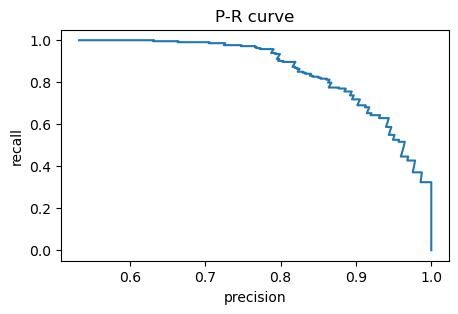

In [5]:
plt.figure(figsize=(5,3))
plt.plot(p,r)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('P-R curve')
plt.show()


## Quiz 2
What's the (p,r) coordinate on the curve if p_crit = 0?

## The logloss metric

### <center>$logloss = - \frac{1}{m}\sum_{i=0}^{m-1} (y_{i, true}\ln(p_{i, pred}) + (1-y_{i, true})\ln(1-p_{i, pred}))$</center>
- $p_{pred}$ is the predicted probability of the **positive class**
- the predicted probabilities are not converted into predicted classes
- excellent choice if you need accurate probabilities (e.g., when it is expensive/costly to act due to limited resources so you need to rank your points based on probabilities)
- two scenarios:
   - y_true = 0 - left term disappears
   - y_true = 1 - right term disappears
- log(0) is undefined
   - $p_{pred}$ is replaced with $\max(\min(p,1-10^{-15}),10^{-15})$ to avoid this issue

### The extreme cases
- the classifier is confidently wrong
   - $p_{pred} = 10^{-15}$ for points in class 1
   - $p_{pred} = 1 - 10^{-15}$ for points in class 0
<center>$logloss = -\frac{1}{m}\sum \ln(10^{-15}) = -\ln(10^{-15})$</center>
<center> $logloss \sim  34.5  $</center>

- the classifier is correct
   - $p_{pred} = 10^{-15}$ for points in class 0
   - $p_{pred} = 1 - 10^{-15}$ for points in class 1
<center>$logloss = -\frac{1}{m}\sum (1-0)(1-\ln(1-10^{-15})) = 10^{-15}$ for class 0</center>
<center>$logloss = -\frac{1}{m}\sum 1*\ln(1-10^{-15}) = 10^{-15}$ for class 1</center>
<center>$logloss \sim 0$</center>



In [6]:
from sklearn.metrics import log_loss
print(log_loss(y_true,pred_prob_class1))
help(log_loss)

0.3501519054532857
Help on function log_loss in module sklearn.metrics._classification:

log_loss(y_true, y_pred, *, normalize=True, sample_weight=None, labels=None)
    Log loss, aka logistic loss or cross-entropy loss.

    This is the loss function used in (multinomial) logistic regression
    and extensions of it such as neural networks, defined as the negative
    log-likelihood of a logistic model that returns ``y_pred`` probabilities
    for its training data ``y_true``.
    The log loss is only defined for two or more labels.
    For a single sample with true label :math:`y \in \{0,1\}` and
    a probability estimate :math:`p = \operatorname{Pr}(y = 1)`, the log
    loss is:

    .. math::
        L_{\log}(y, p) = -(y \log (p) + (1 - y) \log (1 - p))

    Read more in the :ref:`User Guide <log_loss>`.

    Parameters
    ----------
    y_true : array-like or label indicator matrix
        Ground truth (correct) labels for n_samples samples.

    y_pred : array-like of float, sh

## <font color='LIGHTGRAY'> Evaluation metrics in supervised ML, part 2, predicted probabilities and regression</font>

<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Summarize the ROC and precision-recall curves, and the logloss metric</font>
- **Describe the most commonly used regression metrics**


## Regression metrics
- the target variable is continuous
- the predicted values are also continuous
- regression metrics measure some type of difference between y (true values) and y' (predicted values)

### Mean Squared Error 

### <center>$MSE(y,y') = \frac{1}{m}\sum_{i=1}^{m}(y_i-y_i')^2$</center>

<center><img src="../figures/polifit_1.jpg" width="450"></center>

#### The unit of MSE is not the same as the target variable.

### Root Mean Square Error

### <center>$RMSE(y,y') = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(y_i-y_i')^2}$</center>


### Mean Absolute Error

### <center>$MAE(y,y') = \frac{1}{m}\sum_{i=1}^{m}|y_i-y_i'|$</center>

#### Both RMSE and MAE have the same unit as the target variable.


## R2 score - coefficient of determination

### <center>$R^2(y,y') = 1 - \frac{\sum_{i=1}^{m}(y_i-y_i')^2}{\sum_{i=1}^{m}(y_i-\bar{y})^2}$,</center>
<center>where $\bar{y}$ is the mean of $y$.</center>

- R2 = 1 is the perfect regression model ($y == y'$)
- R2 = 0 is as good as a constant model that always predicts the expected value of y ($\bar{y}$)
- R2 < 0 is a bad regression model

#### R2 is dimensionless.

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
help(mean_squared_error)


Help on function mean_squared_error in module sklearn.metrics._regression:

mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')
    Mean squared error regression loss.

    Read more in the :ref:`User Guide <mean_squared_error>`.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.

    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.

    multioutput : {'raw_values', 'uniform_average'} or array-like of shape             (n_outputs,), default='uniform_average'
        Defines aggregating of multiple output values.
        Array-like value defines weights used to average errors.

        'raw_values' :
            Returns a full set of errors in case of multioutput input.

        'uniform_average' :
            Er

- RMSE is not implemented in sklearn, but you can calculate it as `np.sqrt(mean_squared_error(y_true,y_pred))`
- you can find more on regression metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

## Quiz 3
Read in `data/reg_preds.csv`. It contains two columns: 

- y_true: value of owner-occupied homes in $1000's in Boston
- y_pred: predictions of a regression model

What's the ratio between the MSE and the variance of the home values? How does this ratio relate to the R2 score?

## Mudcard